In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import pyqg.diagnostic_tools
from strucFunct import *
%matplotlib inline

from dask.diagnostics import ProgressBar

In [43]:
# Imports auxiliary functions
import importlib

import strucFunct2_ai
importlib.reload(strucFunct2_ai)
from strucFunct2_ai import *

# Runs Two-layer QG Model

The model configuration is similar to the high-resolution eddy configuration of \cite{ross2022}, which generates a field of isotropic eddies. The configuration is a flat bottom doubly periodic square domain of size $L_x =L_y=1000$ km, with $n_x=n_y=256$ corresponding to a uniform grid spacing of $\sim 3.9$ km. The simulation is forced with a mean vertical shear, set by $U_1=0.025$ m s$^{-1}$ and $U_2=0$ in the top and bottom layer of mean thicknesses $H_1=500$ m and $H_2=2000$ m. Layer densities are chosen such that the Rossby radius $r_d=15$~km (characteristic of high-latitude environments), which is large enough to be well resolved on the chosen grid. Also, $\beta=1.5 \times 10^{-11}$ m$^{-1}$ s$^{-1}$ and  bottom drag is $r_{ek}=5.787 \times 10^{-7}$ s$^{-1}$. The model is spun up for five years and run for 15 years with a time step of 1 hr. For computational convenience, we saved and used daily averaged horizontal velocity fields. We only used the model's upper layer. 

In [3]:
def run_simulation(m, sampling_freq):
    """
    m: pyqg model object
    sampling_freq: frequency in numerical timesteps in which to extract dataset
    """
    snapshots = []
    while eddy_model.t < eddy_model.tmax:
        if eddy_model.tc % sampling_freq == 0:
            ds=eddy_model.to_dataset().copy(deep=True)
            snapshots.append(ds)
        eddy_model._step_forward()
    return snapshots

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 10000, Time: 3.60e+07, KE: 3.92e-06, CFL: 0.023
INFO: Step: 20000, Time: 7.20e+07, KE: 6.16e-04, CFL: 0.206
INFO: Step: 30000, Time: 1.08e+08, KE: 5.86e-04, CFL: 0.214
INFO: Step: 40000, Time: 1.44e+08, KE: 6.10e-04, CFL: 0.210
INFO: Step: 50000, Time: 1.80e+08, KE: 5.93e-04, CFL: 0.208
INFO: Step: 60000, Time: 2.16e+08, KE: 6.27e-04, CFL: 0.225
INFO: Step: 70000, Time: 2.52e+08, KE: 6.02e-04, CFL: 0.193
INFO: Step: 80000, Time: 2.88e+08, KE: 6.38e-04, CFL: 0.213
INFO: Step: 90000, Time: 3.24e+08, KE: 6.61e-04, CFL: 0.245
INFO: Step: 100000, Time: 3.60e+08, KE: 6.36e-04, CFL: 0.280
INFO: Step: 110000, Time: 3.96e+08, KE: 5.88e

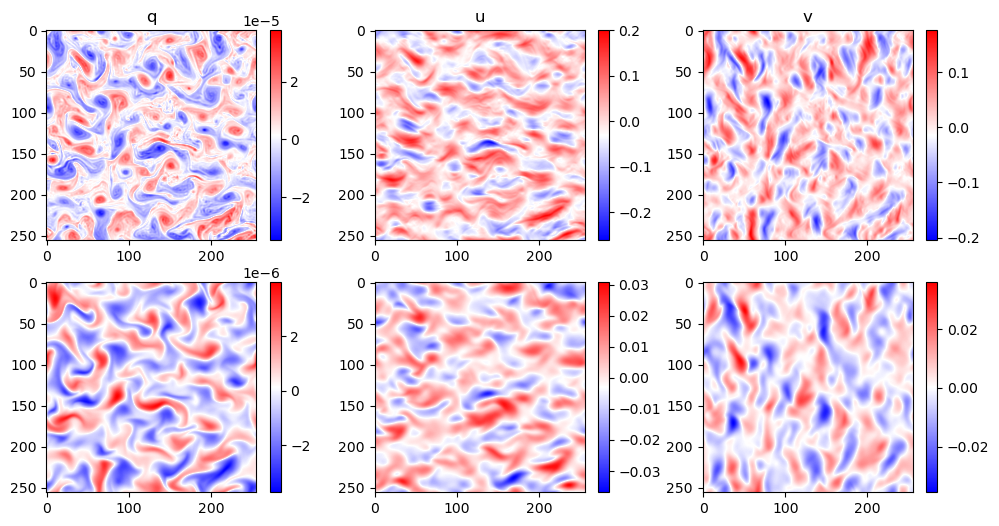

In [4]:
# Run with snapshots
year = 24*60*60*360. #seconds

eddy_model = pyqg.QGModel(nx=256.0,dt=3600.0, tmax=20*year, ntd=1,twrite=10000, 
                          tavestart=155520000.0, taveint= 86400, 
                          beta=1.5e-11, rd=15000.0, delta=0.25, 
                          H1=500, U1=0.025, U2=0.0)

# Saves snapshots
snaps=run_simulation(eddy_model, 24) # Saves data 
# Convert to xarray data 
eddyrun_lev = xr.concat(snaps, dim='time')

snap_index=-1
cmap="bwr"
plt.figure(figsize=(12,6))
plt.subplot(2,3,1)
plt.title("q")
plt.imshow(snaps[snap_index].q[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(snaps[snap_index].q[0][1],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,2)
plt.title("u")
plt.imshow(snaps[snap_index].u[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(snaps[snap_index].u[0][1],cmap=cmap)
plt.colorbar()

plt.subplot(2,3,3)
plt.title("v")
plt.imshow(snaps[snap_index].v[0][0],cmap=cmap)
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(snaps[snap_index].v[0][1],cmap=cmap)
plt.colorbar()

In [5]:
# Removes some variables and saves data
delvar = ["qh", "uh", "vh", "ph",
          "dqhdt", "Ubg", "Qy", "dqdt",
          "p", "ufull", "vfull"]
eddyrun_lev = eddyrun_lev.drop_vars(delvar)

eddyrun_lev.to_netcdf('/data/SO3/manuelogv/MethodsKEFlux/QGModelRun20years.nc')

### Use line below if kernel dies

In [4]:
# Load data
fileQG = '/data/SO3/manuelogv/MethodsKEFlux/QGModelRun20years.nc'

eddyrun_lev = xr.open_dataset(fileQG)

## Calculates first-, second-, and third-order velocity fluctuations

#### estimation of two-point differences in scalars or vectors, such as velocity differences:

\begin{equation}
\delta \mathbf{u}(\mathbf{s},\mathbf{r}, t) = \mathbf{u}(\mathbf{s} + \mathbf{r}, t) - \mathbf{u}(\mathbf{s}, t),\label{eq1}    
\end{equation}

where $\delta \mathbf{u}$ represents the velocity difference between two points $\mathbf{s}$ and $\mathbf{s} + \mathbf{r}$ separated by the vector $\mathbf{r}$ at time $t$. These velocity differences are the central focus of this study. To avoid reliance on fixed geographical coordinates, we decompose $\delta \mathbf{u}$ into longitudinal and transverse components $\mathbf{\delta u}=(\delta u_{L}, \delta u_{T})$:

\begin{equation}
    \delta u_{L}=\delta \mathbf{u}\cdot\frac{\mathbf{r}}{|\mathbf{r}|},\ \ \ \
    \delta u_{T}=\frac{\mathbf{\widehat{z}}\cdot(\delta \mathbf{u}\times \mathbf{r})}{|\mathbf{r}|}, \label{eq2}
\end{equation}

where $\mathbf{\widehat{\mathbf{z}}}$ is the vertical unit vector.

In [5]:
# Calculates structure functions
shiftdim = 'x','y'
maxcorr = 60
grid = 'm'

# rbins = np.arange(1e3, 2e5, 4e3)

# Gets last five years of data
nyears = 5
yr = 365

i1 = -2-yr*nyears
time3y = np.arange(i1, i1 + yr*nyears)

In [6]:
# Chunks data

chx = len(eddyrun_lev.x)
chy = len(eddyrun_lev.y)
cht = len(eddyrun_lev.time)

chunks = {'x': chx, 'y': chy, 'time': cht}

Udsn = eddyrun_lev.isel(lev=0, time=time3y).chunk(chunks)
Udsn

<xarray.Dataset>
Dimensions:  (time: 1825, y: 256, x: 256, lev_mid: 1, l: 256, k: 129)
Coordinates:
  * time     (time) float64 4.642e+08 4.643e+08 ... 6.217e+08 6.218e+08
    lev      int64 1
  * lev_mid  (lev_mid) float64 1.5
  * x        (x) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * l        (l) float64 0.0 6.283e-06 1.257e-05 ... -1.257e-05 -6.283e-06
  * k        (k) float64 0.0 6.283e-06 1.257e-05 ... 0.000798 0.0008042
Data variables:
    q        (time, y, x) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
    u        (time, y, x) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
    v        (time, y, x) float64 dask.array<chunksize=(1825, 256, 256), meta=np.ndarray>
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         3600.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         0
    pyqg:tmax:       622080000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

In [7]:
# Takes an example

SFtest = calculateSF_2(Udsn.isel(time=np.arange(0, 15)), maxcorr, shiftdim, grid)

[########################################] | 100% Completed | 383.81 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

In [8]:
SFtest

<xarray.Dataset>
Dimensions:  (x: 256, y: 256, time: 15, dcorr: 3599)
Coordinates:
    lev      int64 1
  * x        (x) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * time     (time) float64 4.642e+08 4.643e+08 ... 4.654e+08 4.654e+08
Dimensions without coordinates: dcorr
Data variables:
    dr       (dcorr, x, y, time) float64 nan nan nan ... 3.259e+05 3.259e+05
    dul      (dcorr, x, y, time) float64 nan nan nan ... 0.1096 0.1127 0.09273
    dut      (dcorr, x, y, time) float64 nan nan nan nan ... 0.167 0.1585 0.132
    du1      (dcorr, x, y, time) float64 nan nan nan ... 0.2766 0.2712 0.2248

Size of Xarray Dataset = 113 GB


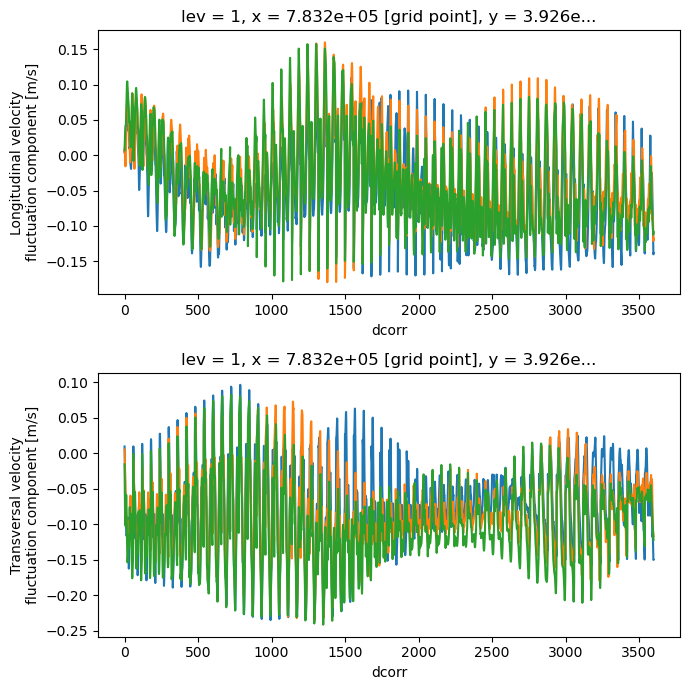

In [13]:
print('Size of Xarray Dataset = ' + str(int(SFtest.nbytes/1e9)) + ' GB')

plt.figure(figsize=(7, 7))
plt.subplot(2, 1, 1)
SFtest.dul.isel(x=200, y=100, time=0).plot()
SFtest.dul.isel(x=200, y=100, time=9).plot()
SFtest.dul.isel(x=200, y=100, time=14).plot()

plt.subplot(2, 1, 2)
SFtest.dut.isel(x=200, y=100, time=0).plot()
SFtest.dut.isel(x=200, y=100, time=9).plot()
SFtest.dut.isel(x=200, y=100, time=14).plot()

plt.tight_layout()

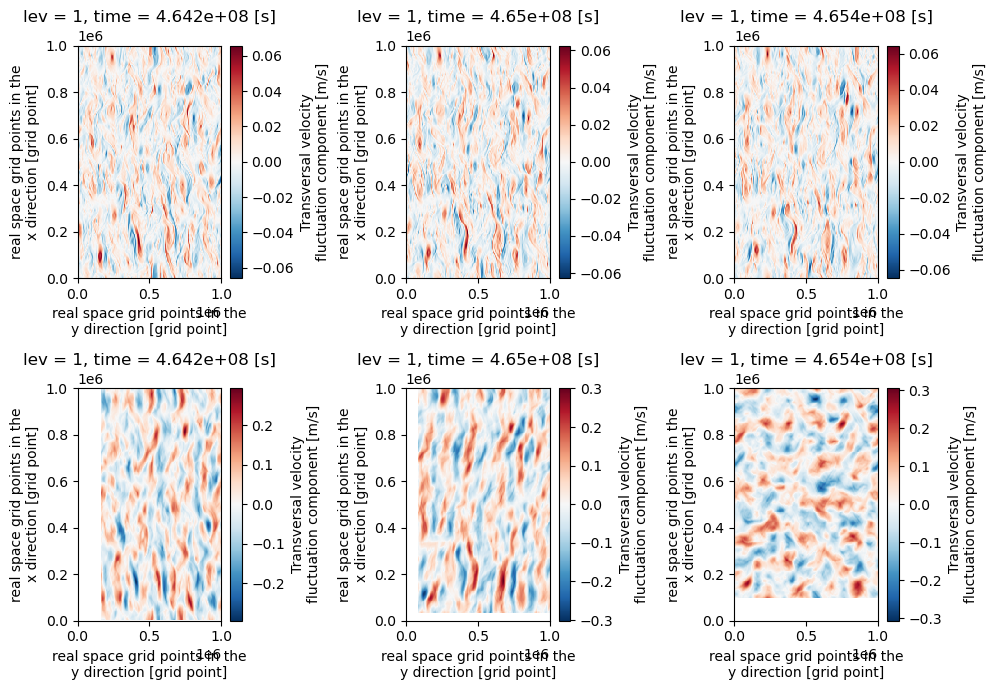

In [14]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
SFtest.dut.isel(time=0, dcorr=0).plot()

plt.subplot(2, 3, 2)
SFtest.dut.isel(time=9, dcorr=0).plot()

plt.subplot(2, 3, 3)
SFtest.dut.isel(time=14, dcorr=0).plot()

plt.subplot(2, 3, 4)
SFtest.dut.isel(time=0, dcorr=100).plot()

plt.subplot(2, 3, 5)
SFtest.dut.isel(time=9, dcorr=500).plot()

plt.subplot(2, 3, 6)
SFtest.dut.isel(time=14, dcorr=1500).plot()

plt.tight_layout()

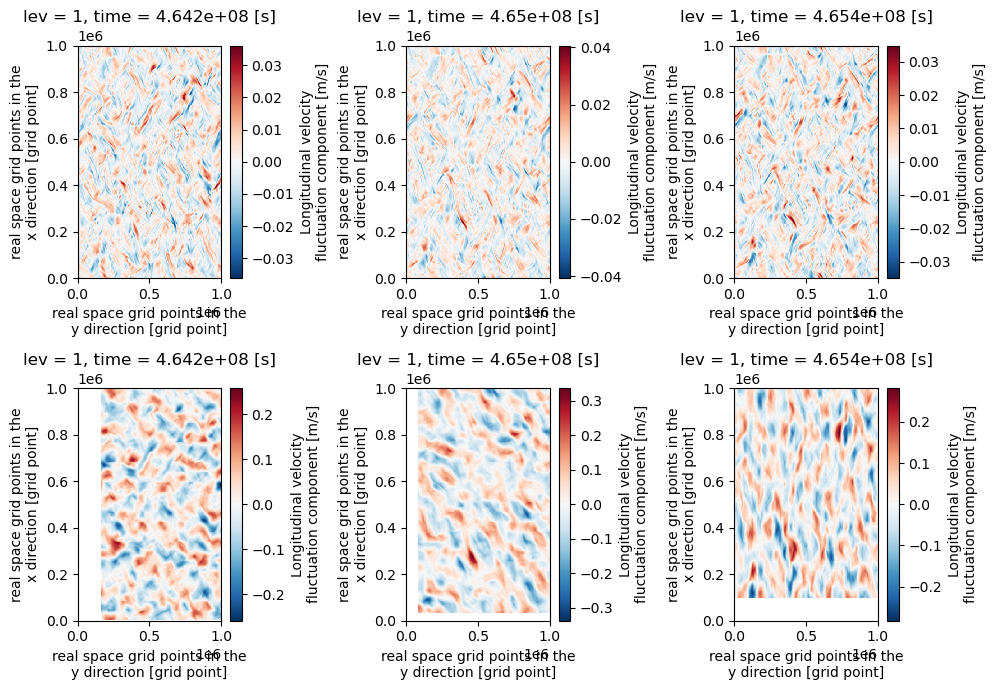

In [15]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 3, 1)
SFtest.dul.isel(time=0, dcorr=0).plot()

plt.subplot(2, 3, 2)
SFtest.dul.isel(time=9, dcorr=0).plot()

plt.subplot(2, 3, 3)
SFtest.dul.isel(time=14, dcorr=0).plot()

plt.subplot(2, 3, 4)
SFtest.dul.isel(time=0, dcorr=100).plot()

plt.subplot(2, 3, 5)
SFtest.dul.isel(time=9, dcorr=500).plot()

plt.subplot(2, 3, 6)
SFtest.dul.isel(time=14, dcorr=1500).plot()

plt.tight_layout()

In [25]:
# Runs code for all datasets
time_indices = np.arange(len(Udsn.time))  # All time indices

# Define the chunk size
chunk_size = 15

# Loop over the time indices in chunks of 15
for start in tqdm(range(0, len(time_indices), chunk_size), desc="Processing Chunks: "):
    end = start + chunk_size
    
    # Ensure that the 'end' index doesn't exceed the total number of time indices
    if end > len(time_indices):
        end = len(time_indices)
    
    # Slice the time indices for the current chunk
    indx_time = time_indices[start:end]
    data = Udsn.isel(time=indx_time).chunk({'x': chx, 'y': chy, 'time': chunk_size})
    
    # Runs code
    SFQG = calculateSF_2(data, maxcorr, shiftdim, grid)
    print('Save {}.nc file'.format(start))
    filessv = '/data/SO3/manuelogv/MethodsKEFlux/rawduLT/' + str(start)
    SFQG.to_netcdf(filesv)

Processing Chunks:   0%|          | 0/122 [00:00<?, ?it/s]

[########################################] | 100% Completed | 554.11 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 0.nc file
[########################################] | 100% Completed | 371.82 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 15.nc file
[########################################] | 100% Completed | 294.40 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 30.nc file
[########################################] | 100% Completed | 276.19 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 45.nc file
[########################################] | 100% Completed | 271.07 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 60.nc file
[########################################] | 100% Completed | 264.38 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 75.nc file
[########################################] | 100% Completed | 236.63 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 90.nc file
[########################################] | 100% Completed | 170.57 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 105.nc file
[########################################] | 100% Completed | 189.39 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 120.nc file
[########################################] | 100% Completed | 343.81 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 135.nc file
[########################################] | 100% Completed | 234.61 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 150.nc file
[########################################] | 100% Completed | 270.01 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 165.nc file
[########################################] | 100% Completed | 253.58 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 180.nc file
[########################################] | 100% Completed | 281.68 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 195.nc file
[########################################] | 100% Completed | 300.16 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 210.nc file
[########################################] | 100% Completed | 268.99 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 225.nc file
[########################################] | 100% Completed | 337.40 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 240.nc file
[########################################] | 100% Completed | 520.42 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 255.nc file
[########################################] | 100% Completed | 381.73 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 270.nc file
[########################################] | 100% Completed | 325.07 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 285.nc file
[########################################] | 100% Completed | 394.87 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 300.nc file
[########################################] | 100% Completed | 317.50 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 315.nc file
[########################################] | 100% Completed | 303.95 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 330.nc file
[########################################] | 100% Completed | 390.36 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 345.nc file
[########################################] | 100% Completed | 306.79 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 360.nc file
[########################################] | 100% Completed | 337.67 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 375.nc file
[########################################] | 100% Completed | 290.84 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 390.nc file
[########################################] | 100% Completed | 258.84 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 405.nc file
[########################################] | 100% Completed | 275.87 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 420.nc file
[########################################] | 100% Completed | 233.75 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 435.nc file
[########################################] | 100% Completed | 275.67 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 450.nc file
[########################################] | 100% Completed | 312.36 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 465.nc file
[########################################] | 100% Completed | 254.68 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 480.nc file
[########################################] | 100% Completed | 306.26 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 495.nc file
[########################################] | 100% Completed | 304.17 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 510.nc file
[########################################] | 100% Completed | 303.52 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 525.nc file
[########################################] | 100% Completed | 340.47 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 540.nc file
[########################################] | 100% Completed | 278.29 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 555.nc file
[########################################] | 100% Completed | 264.47 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 570.nc file
[########################################] | 100% Completed | 294.37 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 585.nc file
[######################################  ] | 97% Completed | 287.56 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 303.55 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 705.nc file
[########################################] | 100% Completed | 288.05 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 720.nc file
[                                        ] | 0% Completed | 10.13 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 276.84 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 825.nc file
[#########################               ] | 64% Completed | 173.09 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 265.10 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 945.nc file
[####################                    ] | 50% Completed | 150.63 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###############                         ] | 38% Completed | 139.99 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 270.63 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1065.nc file
[#####################################   ] | 94% Completed | 200.98 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 279.00 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1155.nc file
[#############                           ] | 33% Completed | 74.26 ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 297.01 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1185.nc file
[                                        ] | 0% Completed | 27.88 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#############                           ] | 33% Completed | 305.19 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#############                           ] | 33% Completed | 211.15 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#####################################   ] | 92% Completed | 174.64 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 410.41 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1320.nc file
[                                        ] | 0% Completed | 31.30 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#############                           ] | 33% Completed | 235.62 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[##############################          ] | 75% Completed | 279.64 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 291.79 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1455.nc file
[                                        ] | 0% Completed | 57.19 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 343.56 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1485.nc file
[#############                           ] | 33% Completed | 146.45 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 302.82 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1545.nc file
[                                        ] | 0% Completed | 55.61 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[####################################    ] | 92% Completed | 286.18 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 284.81 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1650.nc file
[                                        ] | 0% Completed | 6.85 s ms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 352.87 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1680.nc file
[#############                           ] | 33% Completed | 91.24 ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[######################################  ] | 95% Completed | 348.66 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 296.65 s


Concatenating results:   0%|          | 0/3599 [00:00<?, ?it/s]

Save 1785.nc file
[#############                           ] | 33% Completed | 123.95 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Loads all files and chunks it

In [3]:
fileraw = '/data/SO3/manuelogv/MethodsKEFlux/rawduLT/'

# Open the NetCDF files using xarray's open_mfdataset (multi-file dataset)
nc_files = fileraw +'*.nc'  #
dult = xr.open_mfdataset(nc_files, engine='netcdf4', combine='by_coords', 
                          chunks={'time': 100, 'x': 256, 'y': 256, 'dcorr': 10}, 
                          parallel=True)

dult = dult.sortby('time')

In [4]:
print('Size of Xarray dult = {} TB'.format(int(dult.nbytes/1e12)))
dult

Size of Xarray dult = 10 TB


<xarray.Dataset>
Dimensions:  (x: 256, y: 256, time: 1825, dcorr: 3599)
Coordinates:
    lev      int64 1
  * x        (x) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * y        (y) float64 1.953e+03 5.859e+03 9.766e+03 ... 9.941e+05 9.98e+05
  * time     (time) float64 4.642e+08 4.643e+08 ... 6.217e+08 6.218e+08
Dimensions without coordinates: dcorr
Data variables:
    dr       (dcorr, x, y, time) float64 dask.array<chunksize=(10, 256, 256, 15), meta=np.ndarray>
    dul      (dcorr, x, y, time) float64 dask.array<chunksize=(10, 256, 256, 15), meta=np.ndarray>
    dut      (dcorr, x, y, time) float64 dask.array<chunksize=(10, 256, 256, 15), meta=np.ndarray>

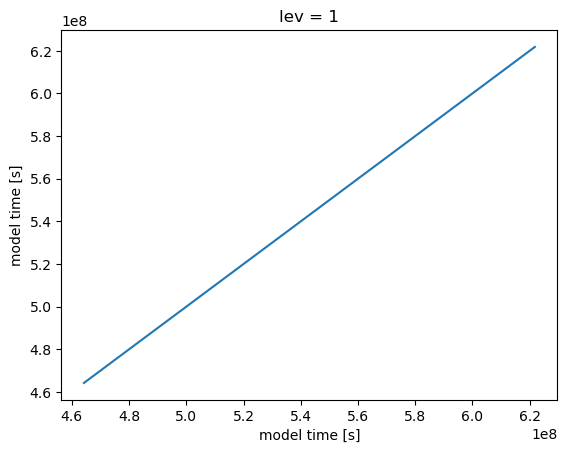

In [5]:
# Checks time has no skips
dult.time.plot()

# Estimating $\delta u1$, $\delta u2$ and $\delta u3$

Here we defined the samples of first-, second-, and third-order structure function for stationary, homogeneous and isotropic flows as:

\begin{equation}
     \delta u1 = \delta u_{L}(\mathbf{s},\mathbf{r}, t) + \delta u_{T}(\mathbf{s},\mathbf{r}, t). 
\end{equation}

Similarly, the samples of the second-order structure are defined as,

\begin{equation}
    \delta u2 = \delta u^2_{L}(\mathbf{s},\mathbf{r}, t) + \delta u^2_{T}(\mathbf{s},\mathbf{r}, t), 
\end{equation}


and for the third-order:

\begin{equation}
    \delta u3 = \delta u_{L}(\mathbf{s},\mathbf{r}, t)[\delta u^2_{L}(\mathbf{s},\mathbf{r}, t) + \delta u^2_{T}(\mathbf{s},\mathbf{r}, t)].
\end{equation}

# Averaging over all positions

$\delta u1$, $\delta u2$, and $\delta u3$ are averaged over all $\mathbf{s}$ positions.

In [5]:
tchunk_size = 15 # time slice length
Ntot = len(dult.time)
chunk_slic = {'time': tchunk_size, 'x': len(dult.x), 'y': len(dult.y), 'dcorr': 3599}
dult = dult.chunk(chunk_slic)

output_list = []
ii = 0

for start_time in tqdm(range(0, Ntot, tchunk_size), desc="Time slice", position=2):
    # Ensure the end time does not exceed the total length of the 'time' dimension
    end_time = min(start_time + tchunk_size, len(dult['time']))
    
    # Slice the data to include the current chunk
    data_slice = dult.isel(time=slice(start_time, end_time))
    
    # Calculates du1, du2 and du3
    sf2, sf3 = SF2_3(data_slice.dul, data_slice.dut)
    data_slice['du2'] = sf2
    data_slice['du3'] = sf3
    
    # Averages over all $s$ positions
    with ProgressBar():
        data_avers = data_slice.mean(dim=('x','y'), skipna=True).compute()
    
    fileSp = '/data/SO3/manuelogv/MethodsKEFlux/spatialaverduLT/SF_spatialaver_' + str(ii) + '.nc'
    print('Save SF_spatialaver_{}.nc file'.format(ii))
    data_avers.to_netcdf(fileSp)
     
    ii = ii + 1

Time slice:   0%|          | 0/122 [00:00<?, ?it/s]

[########################################] | 100% Completed | 14m 41s
Save SF_spatialaver_0.nc file
[########################################] | 100% Completed | 10m 28s
Save SF_spatialaver_1.nc file
[########################################] | 100% Completed | 451.90 s
Save SF_spatialaver_2.nc file
[########################################] | 100% Completed | 497.61 s
Save SF_spatialaver_3.nc file
[########################################] | 100% Completed | 519.54 s
Save SF_spatialaver_4.nc file
[########################################] | 100% Completed | 12m 19s
Save SF_spatialaver_5.nc file
[########################################] | 100% Completed | 477.55 s
Save SF_spatialaver_6.nc file
[####################################### ] | 99% Completed | 578.74 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 457.07 s
Save SF_spatialaver_10.nc file
[########################################] | 100% Completed | 13m 11s
Save SF_spatialaver_11.nc file
[########################################] | 100% Completed | 528.96 s
Save SF_spatialaver_12.nc file
[########################################] | 100% Completed | 13m 33s
Save SF_spatialaver_13.nc file
[########################################] | 100% Completed | 561.91 s
Save SF_spatialaver_14.nc file
[########################################] | 100% Completed | 10m 22s
Save SF_spatialaver_15.nc file
[########################################] | 100% Completed | 10m 5ss
Save SF_spatialaver_16.nc file
[########################################] | 100% Completed | 12m 38s
Save SF_spatialaver_17.nc file
[########################################] | 100% Completed | 10m 8ss
Save SF_spatialaver_18.nc file
[########################################] | 100% Completed | 599.04 s
Save SF_spatialav

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#################################       ] | 83% Completed | 320.32 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 11m 6ss
Save SF_spatialaver_59.nc file
[######                                  ] | 17% Completed | 73.18 ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 12m 18s
Save SF_spatialaver_62.nc file
[####################                    ] | 52% Completed | 206.70 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 511.87 s
Save SF_spatialaver_66.nc file
[###                                     ] | 9% Completed | 39.04 sms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#############################           ] | 74% Completed | 310.16 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#####################                   ] | 54% Completed | 206.78 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 439.20 s
Save SF_spatialaver_72.nc file
[##########                              ] | 26% Completed | 96.08 ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###################################     ] | 89% Completed | 453.74 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#######################                 ] | 57% Completed | 227.59 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 458.81 s
Save SF_spatialaver_76.nc file
[############                            ] | 30% Completed | 119.90 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#####################################   ] | 94% Completed | 346.81 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#################################       ] | 83% Completed | 319.39 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 474.29 s
Save SF_spatialaver_84.nc file
[                                        ] | 1% Completed | 3.83 s ms

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[##############################          ] | 76% Completed | 376.27 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#####################                   ] | 53% Completed | 221.34 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[####################################### ] | 99% Completed | 570.58 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[##################                      ] | 45% Completed | 340.18 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[##############################          ] | 77% Completed | 11m 2sss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[####################################### ] | 99% Completed | 597.17 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[######################                  ] | 56% Completed | 315.43 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[##############                          ] | 37% Completed | 198.57 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[####################################### ] | 99% Completed | 537.69 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#################################       ] | 84% Completed | 424.60 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###################                     ] | 48% Completed | 218.81 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#####################                   ] | 53% Completed | 236.62 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed | 459.70 s
Save SF_spatialaver_103.nc file
[########                                ] | 20% Completed | 87.55 ss

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#########################               ] | 63% Completed | 258.02 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[################                        ] | 41% Completed | 167.29 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[################################        ] | 81% Completed | 336.45 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################                ] | 61% Completed | 253.30 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[######################################  ] | 96% Completed | 411.35 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###########################             ] | 69% Completed | 298.17 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###########################             ] | 68% Completed | 255.01 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###############                         ] | 39% Completed | 161.90 s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Loads files with velocity fluctuations averaged spatially

In [21]:
fileaver = '/data/SO3/manuelogv/MethodsKEFlux/spatialaverduLT/'

# Open the NetCDF files using xarray's open_mfdataset (multi-file dataset)
nc_files3 = fileaver +'*.nc'  #
dult_aver = xr.open_mfdataset(nc_files3, engine='netcdf4', combine='by_coords')

dult_aver = dult_aver.sortby('time').chunk({'time': 1825, 'dcorr': 2}).load()

In [22]:
print('Size of Xarray dult_aver = {} MB'.format(int(dult_aver.nbytes/1e6)))
dult_aver

Size of Xarray dult_aver = 262 MB


<xarray.Dataset>
Dimensions:  (time: 1825, dcorr: 3599)
Coordinates:
    lev      int64 1
  * time     (time) float64 4.642e+08 4.643e+08 ... 6.217e+08 6.218e+08
Dimensions without coordinates: dcorr
Data variables:
    dr       (dcorr, time) float64 3.906e+03 3.906e+03 ... 3.259e+05 3.259e+05
    ulls     (dcorr, time) float64 -2.825e-20 1.597e-20 ... 6.107e-05 7.843e-05
    utts     (dcorr, time) float64 -1.111e-06 -1.229e-06 ... 0.005195 0.005232
    du2      (dcorr, time) float64 0.0001858 0.0001847 ... 0.0109 0.01093
    du3      (dcorr, time) float64 -1.23e-07 -1.259e-07 ... -2.821e-05

Text(0, 0.5, '$\\delta u3(\\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

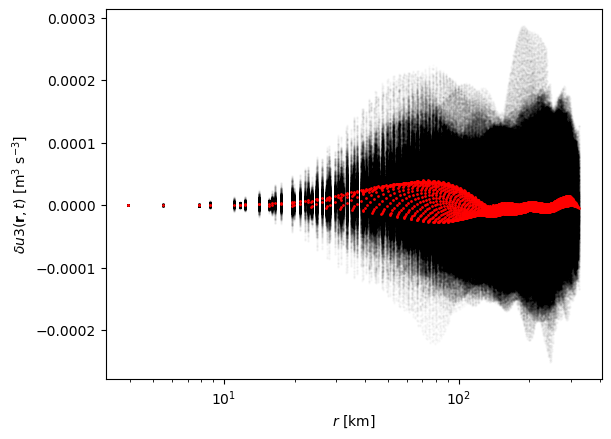

In [30]:
plt.semilogx(dult_aver.dr*1e-3, dult_aver.du3, '.k', markersize=2, alpha=0.01)
plt.semilogx(dult_aver.dr.mean('time')*1e-3, dult_aver.du3.mean('time'), '.r', markersize=2)
plt.xlabel('$r$ [km]')
plt.ylabel('$\delta u3(\mathbf{r}, t)$ [m$^3$ s$^{-3}$]')

# Averages velocity fluctuations over all orientations

In [41]:
# Defines distance bins 
dr = 5000 # meters
rbins = np.arange(0, 3e5, dr)
mid_rbins = 0.5*(rbins[:-1] + rbins[1:])

[     0.   5000.  10000.  15000.  20000.  25000.  30000.  35000.  40000.
  45000.  50000.  55000.  60000.  65000.  70000.  75000.  80000.  85000.
  90000.  95000. 100000. 105000. 110000. 115000. 120000. 125000. 130000.
 135000. 140000. 145000. 150000. 155000. 160000. 165000. 170000. 175000.
 180000. 185000. 190000. 195000. 200000. 205000. 210000. 215000. 220000.
 225000. 230000. 235000. 240000. 245000. 250000. 255000. 260000. 265000.
 270000. 275000. 280000. 285000. 290000. 295000.]
[  2500.   7500.  12500.  17500.  22500.  27500.  32500.  37500.  42500.
  47500.  52500.  57500.  62500.  67500.  72500.  77500.  82500.  87500.
  92500.  97500. 102500. 107500. 112500. 117500. 122500. 127500. 132500.
 137500. 142500. 147500. 152500. 157500. 162500. 167500. 172500. 177500.
 182500. 187500. 192500. 197500. 202500. 207500. 212500. 217500. 222500.
 227500. 232500. 237500. 242500. 247500. 252500. 257500. 262500. 267500.
 272500. 277500. 282500. 287500. 292500.]


In [44]:
# Averages all orientations
dudlt_aver_angl = process_SF_samples(dult_aver, rbins, mid_rbins)

  0%|          | 0/1825 [00:00<?, ?it/s]

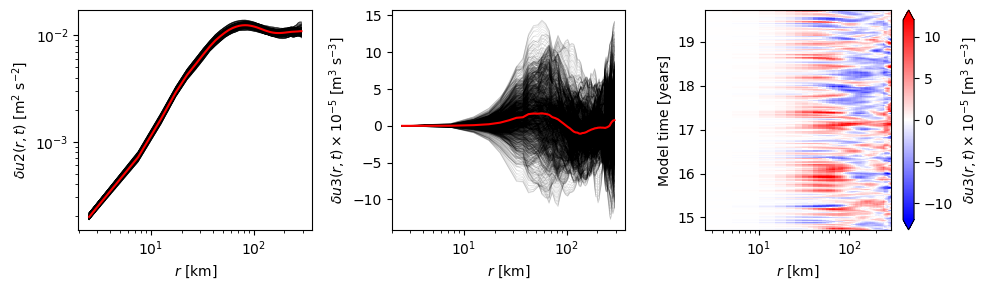

In [66]:
plt.figure(figsize=(10, 3))

rx, tx = np.meshgrid(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.time/86400/365)


plt.subplot(1,3,1)
plt.loglog(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du2.T, '-k', linewidth=0.5, alpha=0.1)
plt.loglog(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du2.T.mean('time'), '-r', linewidth=1.5)
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u2(r, t)$ [m$^2$ s$^{-2}$]')

plt.subplot(1,3,2)
plt.semilogx(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du3.T*1e5, '-k', linewidth=0.5, alpha=0.1)
plt.semilogx(dudlt_aver_angl.dr.mean('time')*1e-3, dudlt_aver_angl.du3.T.mean('time')*1e5, '-r', linewidth=1.5)
plt.xlabel('$r$ [km]')
plt.ylabel('$\\delta u3(r, t) \\times 10^{-5}$ [m$^3$ s$^{-3}$]')

plt.subplot(1,3,3)
plt.pcolormesh(rx, tx, dudlt_aver_angl.du3*1e5, cmap='bwr', vmin=-12, vmax=12)
plt.xscale('log')
plt.xlabel('$r$ [km]')
plt.ylabel('Model time [years]')
plt.xlim(np.min(rx, axis=(0, 1)), np.max(rx, axis=(0, 1)))
col = plt.colorbar(extend='both')
col.set_label('$\\delta u3(r, t) \\times 10^{-5}$ [m$^3$ s$^{-3}$]')

plt.tight_layout()

In [ ]:
# Saves file
dudlt_aver_angl.to_netcdf('/data/SO3/manuelogv/MethodsKEFlux/SFQG_aver_pos_orien_5yearb.nc')

# Runs model and saves hourly outputs of the last month of the 20 year run

In [14]:
# Run with snapshots
year = 24*60*60*360. #seconds
tmax = 86400*365*10
tavent = tmax-86400*30

def run_simulation2(m, sampling_freq, tavestart):
    """
    m: pyqg model object
    sampling_freq: frequency in numerical timesteps in which to extract dataset
    """
    snapshots = []
    while eddy_model.t < eddy_model.tmax:
        if eddy_model.tc % sampling_freq == 0:
            if eddy_model.t > tavestart:
                ds=eddy_model.to_dataset().copy(deep=True)
                snapshots.append(ds)
        eddy_model._step_forward()
    return snapshots

eddy_model = pyqg.QGModel(nx=256.0, dt=3600.0, tmax=tmax, ntd=1, twrite=5000, 
                          tavestart=tavent, taveint= 1, 
                          beta=1.5e-11, rd=15000.0, delta=0.25, 
                          H1=500, U1=0.025, U2=0.0)

# Saves snapshots
snapshr = run_simulation2(eddy_model, 1, tavent) # Saves data 
# Convert to xarray data 
eddyrun_hr = xr.concat(snapshr, dim='time')

RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug


RuntimeError: Undefined plan with nthreads. This is a bug

Exception ignored in: 'pyfftw.pyfftw._fftw_plan_with_nthreads_null'
Traceback (most recent call last):
  File "/home/mog002/miniconda3/envs/pygmt/lib/python3.11/site-packages/pyqg/model.py", line 216, in __init__
    PseudoSpectralKernel.__init__(self, nz, ny, nx, ntd,
RuntimeError: Undefined plan with nthreads. This is a bug
INFO:  Logger initialized
INFO: Step: 5000, Time: 1.80e+07, KE: 2.85e-07, CFL: 0.023
INFO: Step: 10000, Time: 3.60e+07, KE: 1.44e-06, CFL: 0.024
INFO: Step: 15000, Time: 5.40e+07, KE: 1.21e-05, CFL: 0.024
INFO: Step: 20000, Time: 7.20e+07, KE: 1.20e-04, CFL: 0.066
INFO: Step: 25000, Time: 9.00e+07, KE: 4.36e-04, CFL: 0.186
INFO: Step: 30000, Time: 1.08e+08, KE: 4.96e-04, CFL: 0.207
INFO: Step: 35000, Time: 1.26e+08, KE: 5.73e-04, CFL: 0.198
INFO: Step: 40000, Time: 1.44e+08, KE: 6.01e-04, CFL: 0.220
INFO: Step: 45000, Time: 1.62e+08, KE: 6.10e-04, CFL: 0.262
INFO: Step: 50000, Time: 1.80e+08, KE: 6.09e-04, CFL: 0.263
INFO: Step: 55000, Time: 1.98e+08, KE: 5.97e-04

In [18]:
# Removes variables
eddyrun_hr = eddyrun_hr.drop_vars(["qh", "uh", "vh", "ph", "dqhdt", "Ubg","Qy", "dqdt", "p", "ufull", "vfull"])

eddyrun_hr.to_netcdf('./QGModelRun1year_1hr.nc')